In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 227ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2448
Epoch 2/50
53/53 [==============================] - 12s 225ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1687
Epoch 3/50
53/53 [==============================] - 14s 277ms/step - loss: 0.0334 - root_mean_squared_error: 0.1829 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1620
Epoch 4/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1624
Epoch 5/50
53/53 [==============================] - 19s 362ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1590
Epoch 6/50
53/53 [==============================] - 19s 370ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734 - val_loss: 0.0237 - 

53/53 [==============================] - 2s 45ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 32/50
53/53 [==============================] - 3s 49ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 33/50
53/53 [==============================] - 2s 46ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 34/50
53/53 [==============================] - 2s 44ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 35/50
53/53 [==============================] - 2s 45ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 36/50
53/53 [==============================] - 26s 504ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0094 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.871371245384216 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

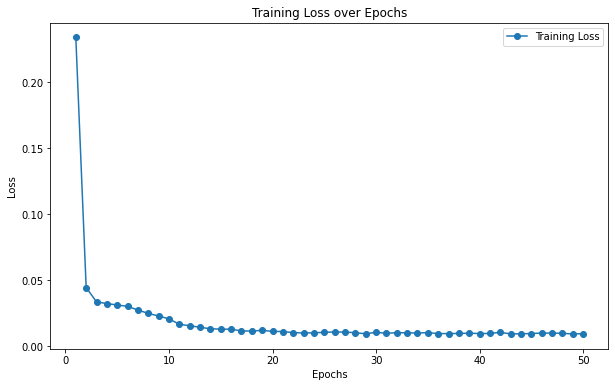

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

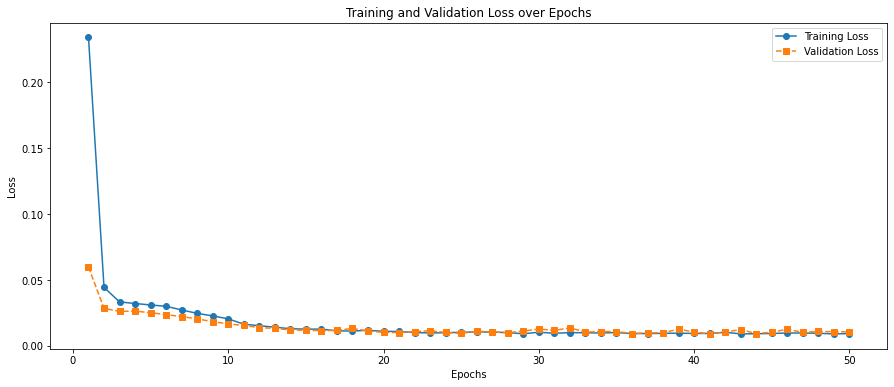

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08273982351223075
MAE : 0.06471134119789836


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,485225.187500,547183.986
1,554988.375000,584596.262
2,605977.125000,584830.109
3,643883.750000,641562.292
4,663556.687500,734946.437
5,662926.062500,777596.225
6,626779.187500,687087.673
7,528340.187500,622337.816
8,409525.343750,467232.074
9,320973.906250,297495.641


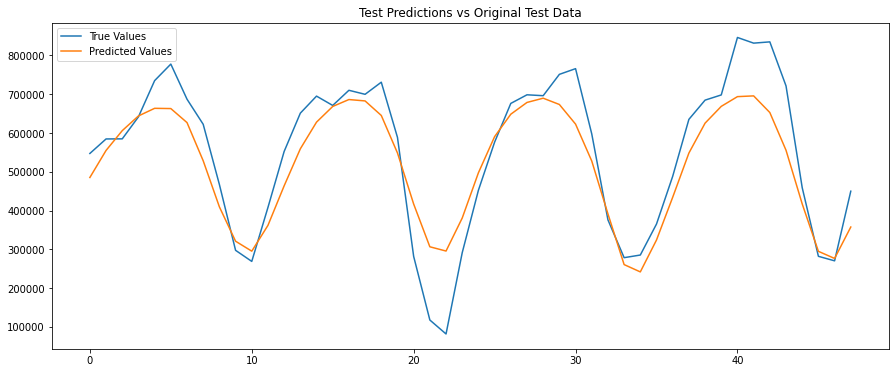

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 17ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

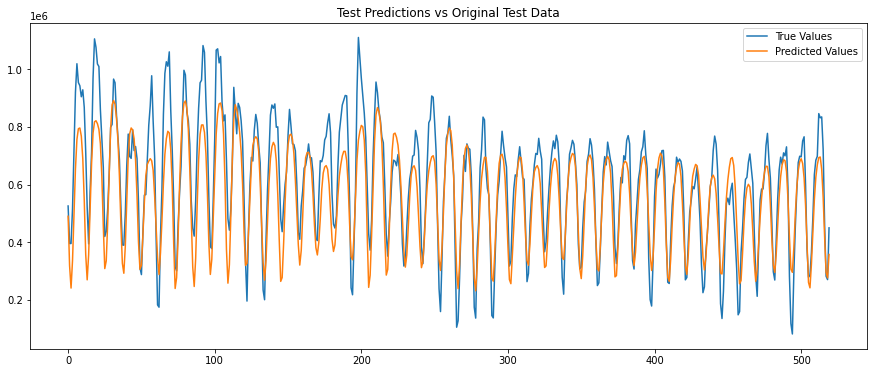

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()